# Mixture of patches classification with QMC



In [1]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install --upgrade  git+https://github.com/fagonzalezo/qmc.git
    !pip install -U tensorflow-addons
else:
    import sys
    sys.path.insert(0, "../")



  Cloning https://github.com/fagonzalezo/qmc.git to /tmp/pip-req-build-buj_isjb
  Running command git clone -q https://github.com/fagonzalezo/qmc.git /tmp/pip-req-build-buj_isjb
  Created wheel for qmc: filename=qmc-0.0.1-py3-none-any.whl size=12796 sha256=f1332bea5d01d71a2cc87d11d69110ed63b11f817ed2489a0a98058e312a4d00
  Stored in directory: /tmp/pip-ephem-wheel-cache-jlaz9vsd/wheels/b2/d2/8d/5870208920445c46dfe694f549251e5f63d7afbee56c01f720
Successfully built qmc
     |████████████████████████████████| 1.1 MB 12.5 MB/s 


In [26]:
!pwd

/content


## Setup

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import qmc.tf.layers as layers
import qmc.tf.models as models

## Prepare the data

In [3]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


11501568/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1) - y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1) - y_test shape: (10000,)


## Configure the hyperparameters

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 28  # We'll resize input images to this size
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
input_dim = 64
num_rff = 512
gamma = 2**-5
n_comp = 80
random_state = 0

mlp_head_units = [256]  # Size of the dense layers of the final classifier


## Use data augmentation

In [12]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        #layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(
        #    height_factor=0.2, width_factor=0.2
        #),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [13]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [15]:

class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, num_patches, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 28 X 28
Patch size: 7 X 7
Patches per image: 16
Elements per patch: 49


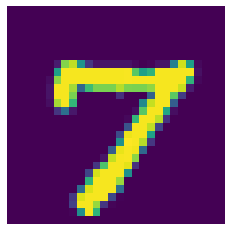

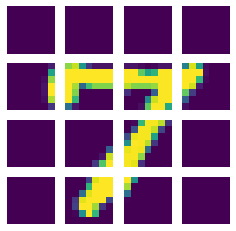

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.reshape([image_size, image_size]))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8").reshape([patch_size, patch_size]))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [18]:
positional_embeddings = np.zeros((num_patches, projection_dim))
for position in range(num_patches):
    for i in range(0, projection_dim, 2):
       positional_embeddings[position, i] = (
                                          np.sin(position / (10000 ** ((2*i) / projection_dim)))
                                            )
       positional_embeddings[position, i + 1] = (
                                              np.cos(position / (10000 ** ((2 * (i + 1) ) / projection_dim)))
                                                )


class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = tf.Variable(initial_value=positional_embeddings,
                                              dtype=tf.float32, 
                                              trainable=False)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.position_embedding = tf.Variable(initial_value=positional_embeddings,
                                      dtype=tf.float32, 
                                      trainable=False)


    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        #encoded = self.projection(patch) + self.position_embedding(positions)
        #encoded = self.projection(patch) + self.position_embedding
        encoded = self.projection(patch)
        return encoded


## Build QMC model


In [23]:

def create_QMC_model():
    inputs = keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    # encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    fm_x1 = layers.QFeatureMapRFF(49, dim=num_rff , gamma=gamma)
    psi_x = fm_x1(patches)
    #ones = tf.ones_like(inputs[:, 0:1])
    #rho_x = tf.keras.layers.concatenate((ones, psi_x), axis=1)
    #rho_x = tf.expand_dims(rho_x, axis=-1)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=psi_x)
    return model


In [24]:
model = create_QMC_model()
model.summary()

ValueError: ignored

## Compile, train, and evaluate the mode

In [ ]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
#vit_classifier.summary()
history = run_experiment(vit_classifier)


Epoch 1/10
211/211 [==============================] - 6s 16ms/step - loss: 0.6631 - accuracy: 0.7945 - top-5-accuracy: 0.9726 - val_loss: 0.1528 - val_accuracy: 0.9568 - val_top-5-accuracy: 0.9977
Epoch 2/10
211/211 [==============================] - 3s 13ms/step - loss: 0.2950 - accuracy: 0.9095 - top-5-accuracy: 0.9954 - val_loss: 0.1007 - val_accuracy: 0.9692 - val_top-5-accuracy: 0.9988
Epoch 3/10
211/211 [==============================] - 3s 14ms/step - loss: 0.2246 - accuracy: 0.9306 - top-5-accuracy: 0.9974 - val_loss: 0.0861 - val_accuracy: 0.9757 - val_top-5-accuracy: 0.9982
Epoch 4/10
211/211 [==============================] - 3s 15ms/step - loss: 0.1839 - accuracy: 0.9431 - top-5-accuracy: 0.9985 - val_loss: 0.0794 - val_accuracy: 0.9777 - val_top-5-accuracy: 0.9987
Epoch 5/10
211/211 [==============================] - 3s 15ms/step - loss: 0.1612 - accuracy: 0.9493 - top-5-accuracy: 0.9986 - val_loss: 0.0671 - val_accuracy: 0.9795 - val_top-5-accuracy: 0.9995
Epoch 6/10
211/

In [ ]:
vit_classifier.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 28, 28, 1)   3           ['input_32[0][0]']               
                                                                                                  
 patches_41 (Patches)           (None, 16, 49)       0           ['data_augmentation[24][0]']     
                                                                                                  
 patch_encoder_31 (PatchEncoder  (None, 16, 64)      4224        ['patches_41[0][0]']             
 )                                                                                         

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. 
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.